In [1]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
script_directory = pathlib.Path("../2.train-VAE/utils/").resolve()
sys.path.insert(0, str(script_directory))
from betavae import BetaVAE, compile_vae, extract_latent_dimensions, weights
from optimize_utils import get_optimizer

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [2]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [3]:
# Load the best hyperparameters
study_name = "BetaVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [4]:
#Initialize the model and optimizer
model = BetaVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

Epoch 1, Train Loss: 194.66850440181904, Val Loss: 257.75120120578345, Test Loss: 248.47984653049045
Epoch 2, Train Loss: 162.64236969449627, Val Loss: 137.9633674621582, Test Loss: 137.05179426405164
Epoch 3, Train Loss: 144.69420730818564, Val Loss: 160.32896677652994, Test Loss: 168.54310099283853
Epoch 4, Train Loss: 132.4755713619403, Val Loss: 125.69814046223958, Test Loss: 130.5127156575521
Epoch 5, Train Loss: 120.82267519822761, Val Loss: 108.132384830051, Test Loss: 111.62621434529622
Epoch 6, Train Loss: 113.17906439482276, Val Loss: 94.01677322387695, Test Loss: 91.98748694525824
Epoch 7, Train Loss: 105.44901542094216, Val Loss: 95.73658413357205, Test Loss: 96.95867072211371
Epoch 8, Train Loss: 101.29374125466418, Val Loss: 91.76888953314887, Test Loss: 91.97513241238065
Epoch 9, Train Loss: 96.64669134794777, Val Loss: 80.00533252292209, Test Loss: 81.35176383124457
Epoch 10, Train Loss: 91.32313396396921, Val Loss: 76.14555994669597, Test Loss: 75.68353292677138
Epoch 

In [5]:
# Save the model
model_path = pathlib.Path("results/best_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [6]:
# Save training history
history = {
    'loss': train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

# Convert the history dictionary into a DataFrame
history_df = pd.DataFrame(history)

# Define the path for the parquet file
history_path = pathlib.Path("results/training_history.parquet")

# Save the DataFrame to a parquet file
history_df.to_parquet(history_path, index=False)

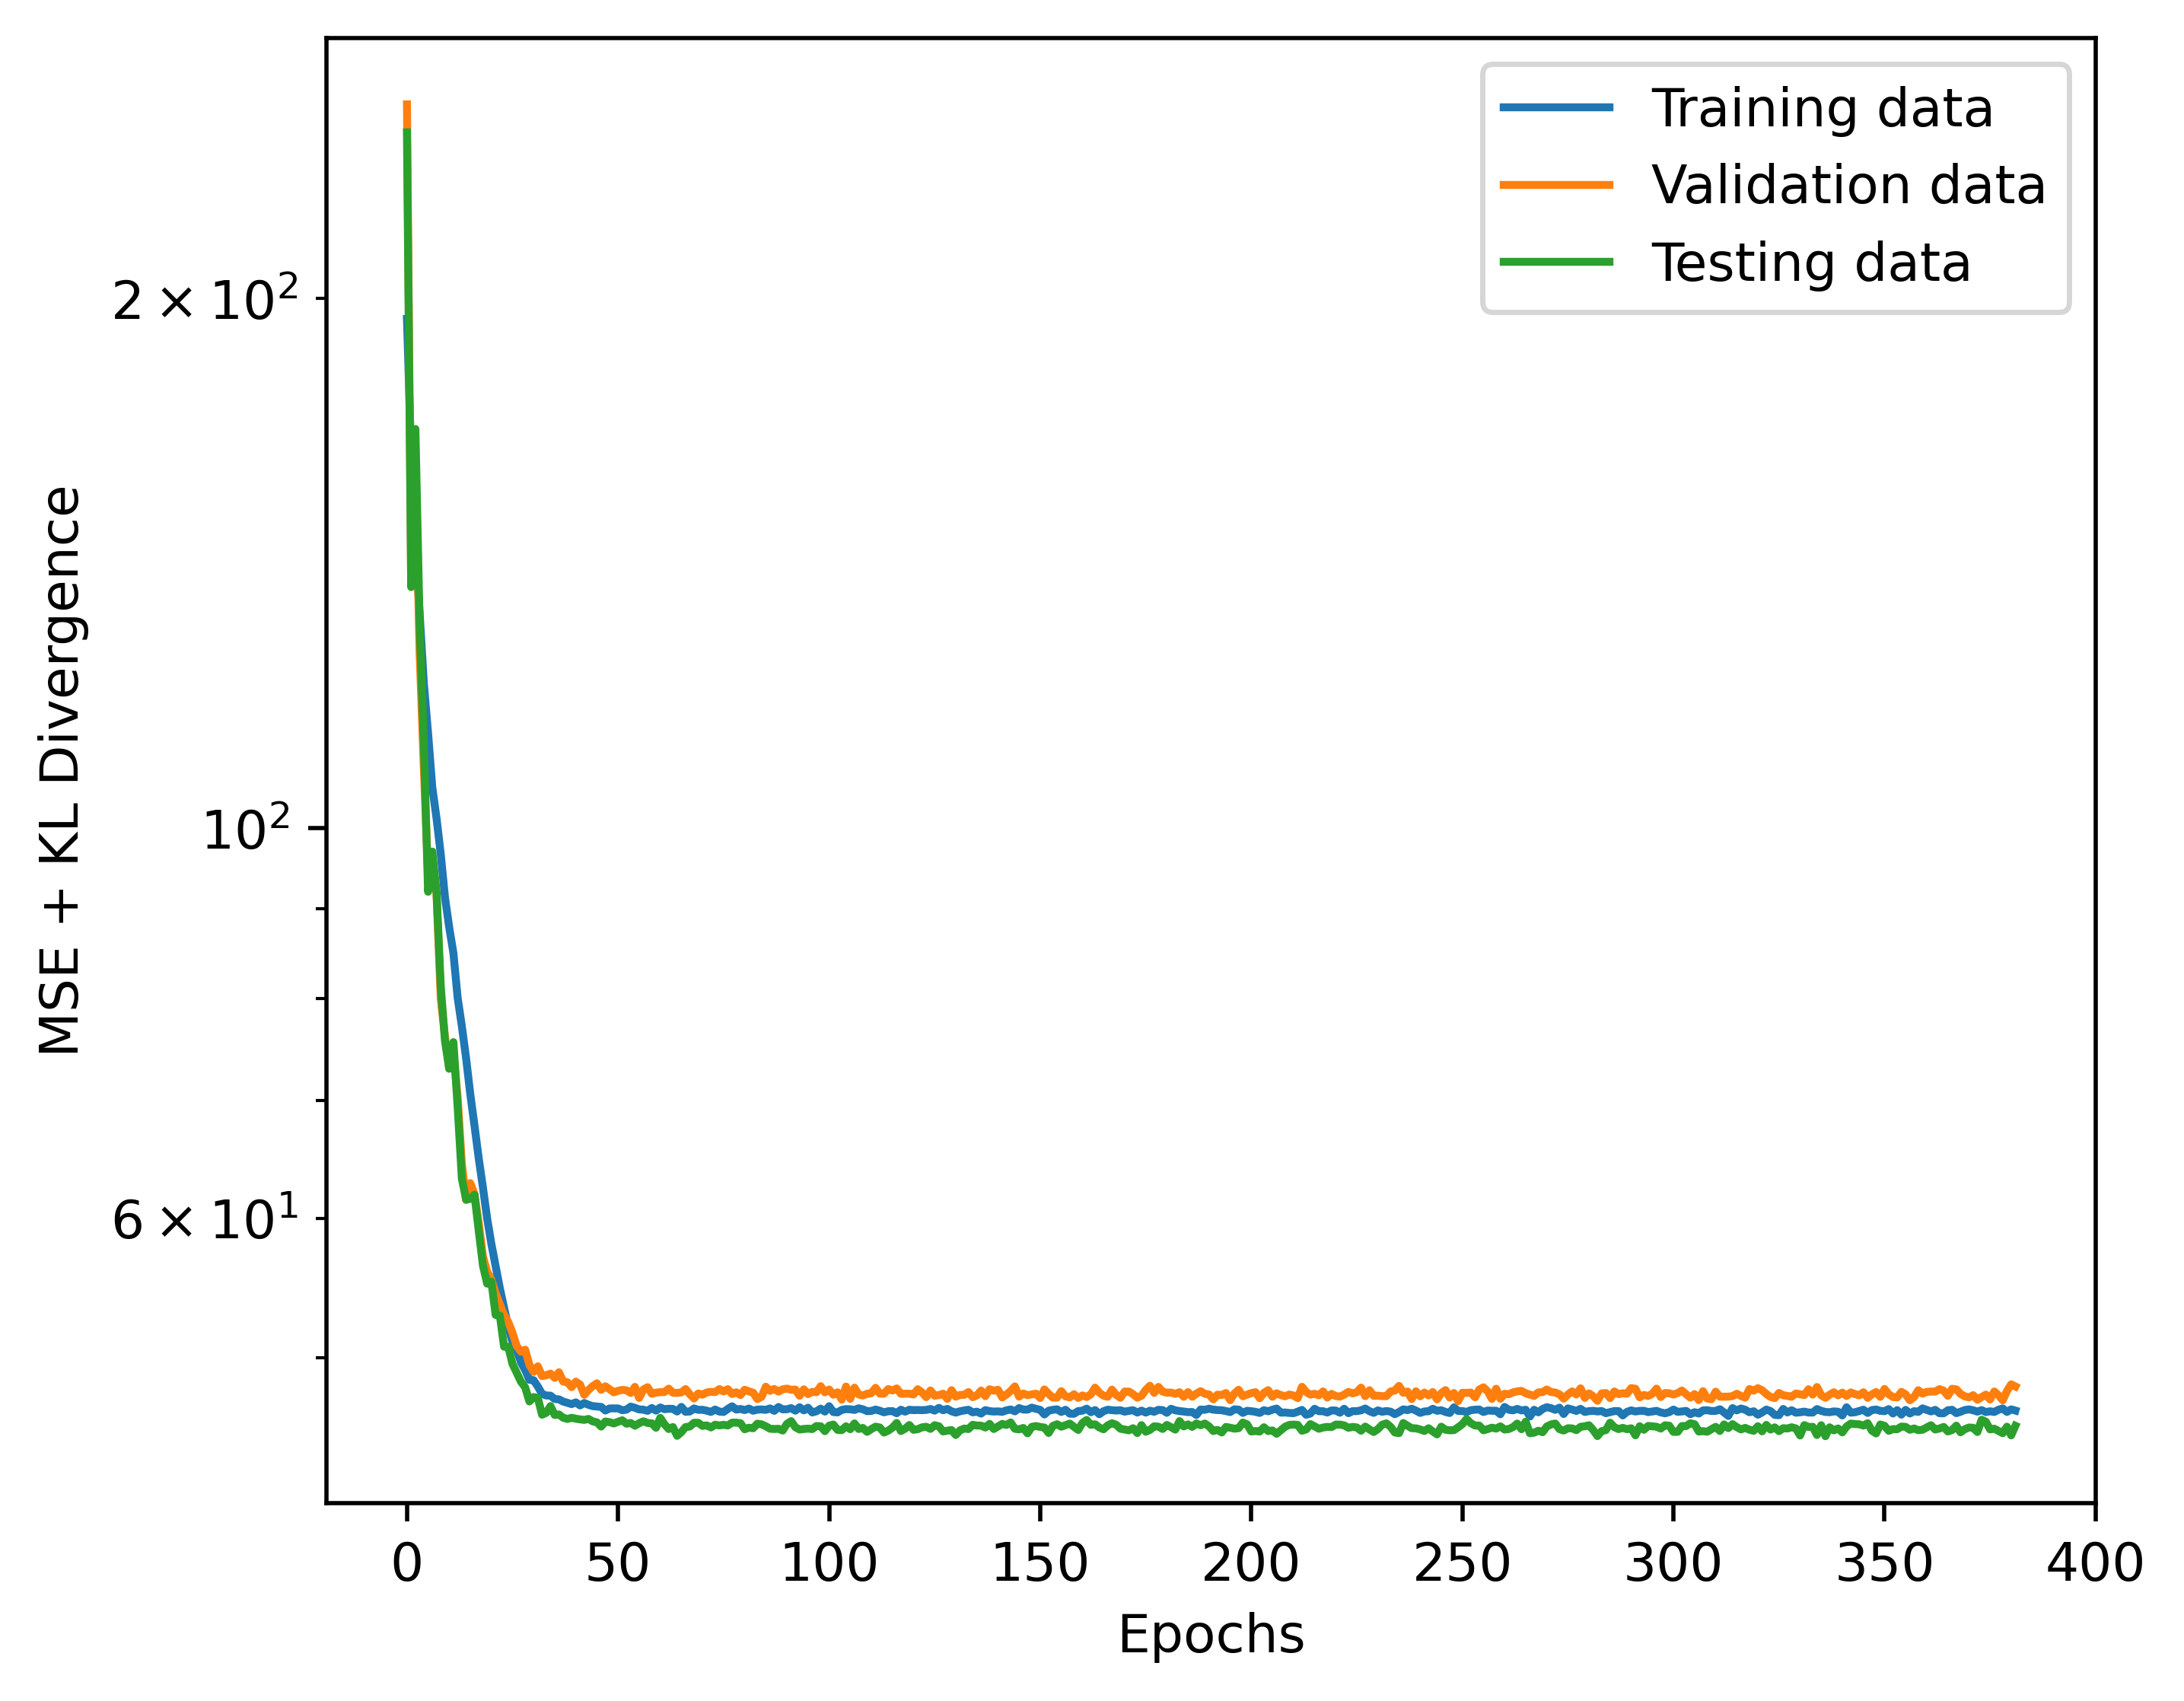

In [7]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(train_loss_history, label="Training data")
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

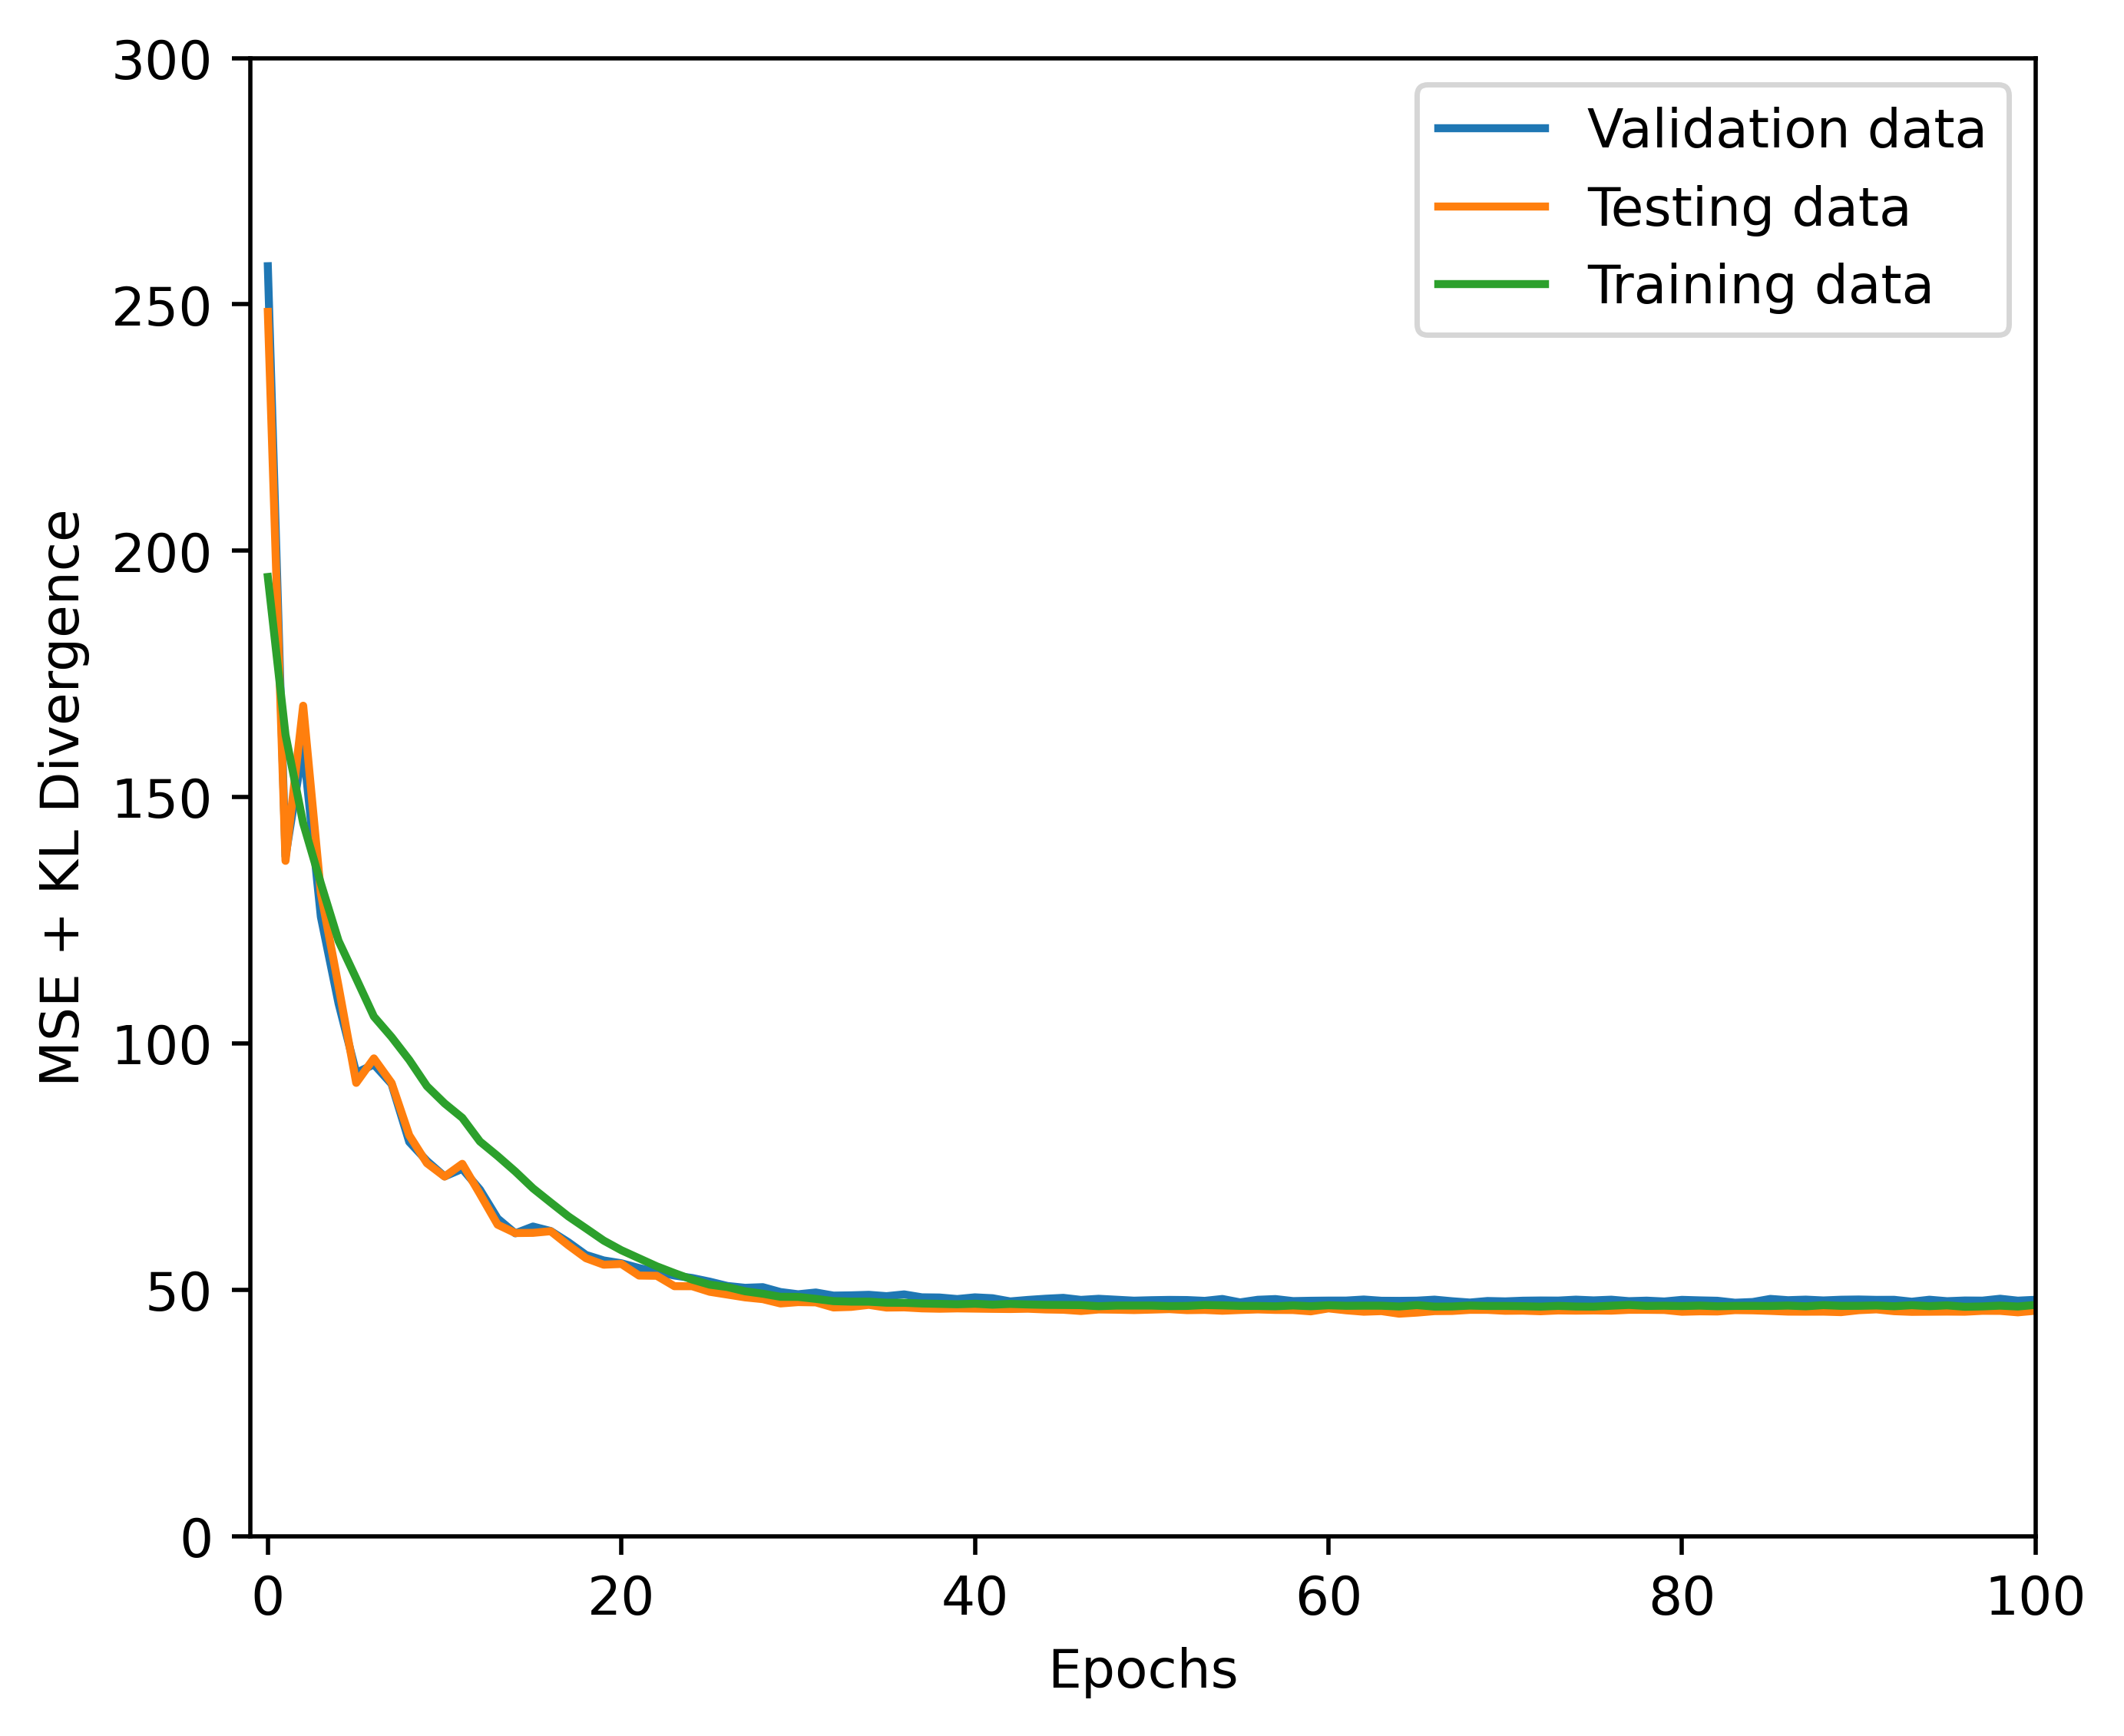

In [8]:
save_path = pathlib.Path("../1.data-exploration/figures/training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,100)
plt.ylim(0,300)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [9]:
# Extract the latent space dimensions
metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.parquet")
metadata = pd.read_parquet(metadata_df_dir)

train_and_test_subbed_dir = pathlib.Path("../0.data-download/data/train_and_test_subbed.parquet")
train_and_test_subbed = pd.read_parquet(train_and_test_subbed_dir)


# Convert DataFrame to NumPy and then Tensor
train_test_array = train_and_test_subbed.to_numpy()
train_test_tensor = torch.tensor(train_test_array, dtype=torch.float32)

#Create TensorDataset and DataLoader
tensor_dataset = TensorDataset(train_test_tensor)
train_and_test_subbed_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)

path = "./results/latent_df.parquet"

latent_df = extract_latent_dimensions(model, train_and_test_subbed_loader, metadata, path)
print(latent_df.head())

      ModelID         0    1         2    3         4    5    6    7    8  \
0  ACH-000499  0.116793  0.0  3.545689  0.0  5.529771  0.0  0.0  0.0  0.0   
1  ACH-001668  0.000000  0.0  3.077717  0.0  4.795898  0.0  0.0  0.0  0.0   
2  ACH-001211  0.153375  0.0  3.289188  0.0  4.810534  0.0  0.0  0.0  0.0   
3  ACH-000997  0.981759  0.0  3.474591  0.0  5.523706  0.0  0.0  0.0  0.0   
4  ACH-001745  0.718717  0.0  2.982288  0.0  4.480220  0.0  0.0  0.0  0.0   

   ...        26        27   28        29   30        31        32        33  \
0  ...  0.000000  4.155077  0.0  1.326112  0.0  4.327004  2.289593  2.347978   
1  ...  0.000000  3.540287  0.0  1.125518  0.0  3.794856  2.156937  1.999025   
2  ...  0.000000  3.672348  0.0  1.189166  0.0  4.018786  2.493559  2.113322   
3  ...  0.038345  3.702794  0.0  0.957900  0.0  4.090379  2.449086  2.523274   
4  ...  0.000000  3.362561  0.0  1.117164  0.0  3.605763  2.393928  2.124230   

    34        35  
0  0.0  2.050914  
1  0.0  1.775838  

In [10]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train"
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
path = "./results/weight_matrix_gsea.parquet"
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = weights(model, train_data, path)